# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Import all the required libraries
import random
import numpy as np
import pandas as pd
import glob
import pathlib, os
from collections import Counter , OrderedDict
import string
import matplotlib.pyplot as plt
import collections

# tensorflow
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from keras.preprocessing.image import load_img
import PIL
import PIL.Image
import time

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
# sklearn
from sklearn.model_selection import train_test_split
np.set_printoptions(precision=4)

from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [6]:
#Import the dataset and read the image into a seperate variable
images='Flickr8K/Images'
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [7]:
 #Import the dataset and read the text file into a seperate variable
text_file = 'Flickr8K/captions.txt'
def load_doc(filename):
    #your code here
    text = open(filename, 'r', encoding = 'utf-8').read()
    
    return text

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


### Visualising some random images

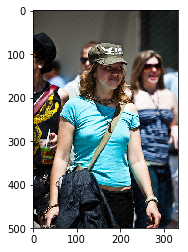

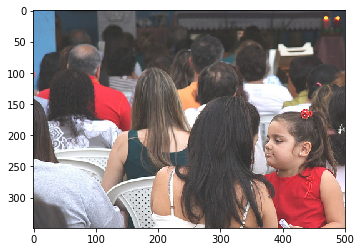

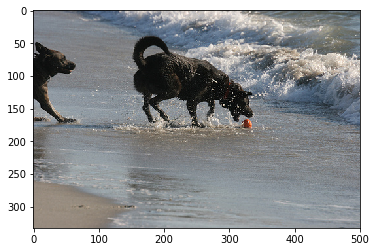

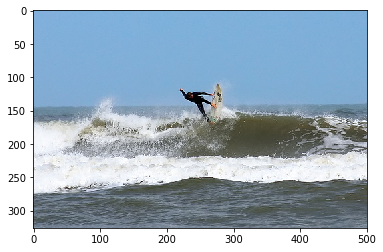

In [8]:
for i in range(1, 400, 100):
    plt.figure()
    img = PIL.Image.open(all_imgs[i])
    plt.imshow(img)

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

### Function to clean captions by removing punctuations marks and other non-alphanumeric characters

In [9]:
def clean_caption(caption):
    table = str.maketrans('','', string.punctuation)
    desc = caption.split() #create a list of words

    # remove the punctuation from each word
    desc = [word.translate(table) for word in desc]
    
    # remove empty strings and strings like 's and a
    desc = [word.strip() for word in desc if len(word.strip()) > 1]
    desc = [word.lower() for word in desc if(word.isalpha())] # convert to lower case and pick only alpha numeric 
    return ' '.join(desc)

# def clean_caption(text):
#     return ''.join(e for e in text if e.isalnum() or e == ' ')

In [10]:
# fubction to append <start> and <end> tokens
def appendDelimitingTokes(caption):
    return '<start> {} <end>'.format(caption)

In [11]:
# get file name from the path
def getFileName(path):
    return path[len(images)+1:]

In [12]:
# function to map images to captions as a dictionary with image path as index. 
def MapImageCaptions(doc):
    captionDict = dict()
    text_lines = doc.split('\n')
    # remove the header line
    text_lines.pop(0)
    text_lines = [t for t in text_lines if len(t)>0]
    for line in text_lines:
        dict_index, dict_val = line.split(',', 1)
        dict_index = images + '/' + dict_index
        if dict_index not in captionDict:
            captionDict[dict_index] = list()
        captionDict[dict_index].append(appendDelimitingTokes(clean_caption(dict_val)))
    return captionDict

In [13]:
captionMappings = MapImageCaptions(doc)
captionMappings

{'Flickr8K/Images/1000268201_693b08cb0e.jpg': ['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
  '<start> girl going into wooden building <end>',
  '<start> little girl climbing into wooden playhouse <end>',
  '<start> little girl climbing the stairs to her playhouse <end>',
  '<start> little girl in pink dress going into wooden cabin <end>'],
 'Flickr8K/Images/1001773457_577c3a7d70.jpg': ['<start> black dog and spotted dog are fighting <end>',
  '<start> black dog and tricolored dog playing with each other on the road <end>',
  '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
  '<start> two dogs of different breeds looking at each other on the road <end>',
  '<start> two dogs on pavement moving toward each other <end>'],
 'Flickr8K/Images/1002674143_1b742ab4b8.jpg': ['<start> little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>',
  '<start> little girl is sitting in

In [14]:
all_img_vector= list(captionMappings.keys()) #store all the image path here
all_img_id= list(map(getFileName, all_img_vector))#store all the image id here
annotations= captionMappings.values() #store all the captions here

# create a data frame
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
print(df.shape)
df.head(5)

(8091, 3)


ID                                       Path  \
0  1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
1  1001773457_577c3a7d70.jpg  Flickr8K/Images/1001773457_577c3a7d70.jpg   
2  1002674143_1b742ab4b8.jpg  Flickr8K/Images/1002674143_1b742ab4b8.jpg   
3  1003163366_44323f5815.jpg  Flickr8K/Images/1003163366_44323f5815.jpg   
4  1007129816_e794419615.jpg  Flickr8K/Images/1007129816_e794419615.jpg   

                                            Captions  
0  [<start> child in pink dress is climbing up se...  
1  [<start> black dog and spotted dog are fightin...  
2  [<start> little girl covered in paint sits in ...  
3  [<start> man lays on bench while his dog sits ...  
4  [<start> man in an orange hat starring at some...

In [15]:
## expand the data frame by creating 1 row for each caption
df = (df
 .set_index(['ID','Path'])['Captions']
 .apply(pd.Series)
 .stack()
 .reset_index()
 .drop('level_2', axis=1)
 .rename(columns={0:'Captions'}))
df.head(5)

ID                                       Path  \
0  1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   

                                            Captions  
0  <start> child in pink dress is climbing up set...  
1      <start> girl going into wooden building <end>  
2  <start> little girl climbing into wooden playh...  
3  <start> little girl climbing the stairs to her...  
4  <start> little girl in pink dress going into w...

In [16]:
df.shape

(40455, 3)

### Each image id has 5 captions associated with it therefore the total dataset has 8091 * 5 = 40455 samples.

In [17]:
# plot the image along with it's captions. 
def image_desc_plotter(start=10, end=15, image_set=all_img_vector):
    npic = 5
    npix = 224
    target_size = (npix,npix,3)

    count = 1
    fig = plt.figure(figsize=(10,20))
    for image in image_set[start:end]:
        image_id = getFileName(image)
        captions = list(df["Captions"].loc[df["ID"]==image_id].values)
        image_load = load_img(image, target_size=target_size)

        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()

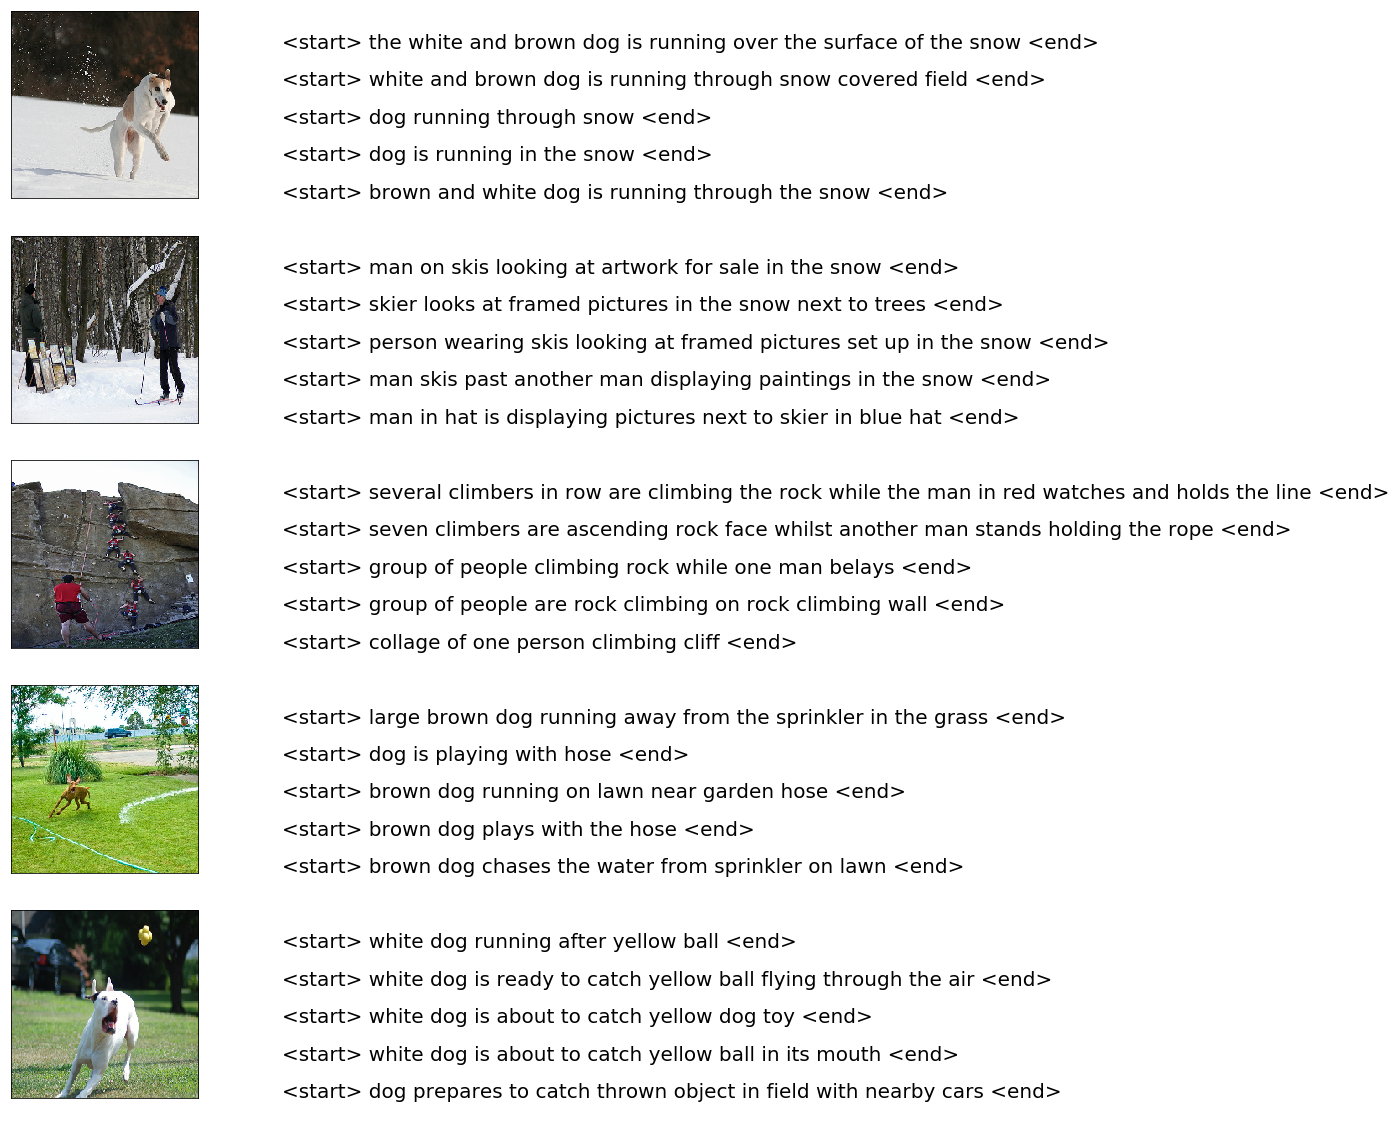

In [18]:
image_desc_plotter()

In [19]:
#Create a list which contains all the captions
#add the <start> & <end> token to all those captions as well
all_annotations = df['Captions'].values #GetAllAnnotations(annotations) #write your code here


#Create a list which contains all the path to the images
all_img_path = all_img_vector#write your code here

print("Total images present in the dataset: " + str(len(all_img_path)))
print("Total count of annotation " + str(len(all_annotations)))

Total images present in the dataset: 8091
Total count of annotation 40455


In [20]:
#Create the vocabulary & the counter for the captions
vocabulary= [word for line in all_annotations for word in line.split()] #write your code here
val_count=Counter(vocabulary)

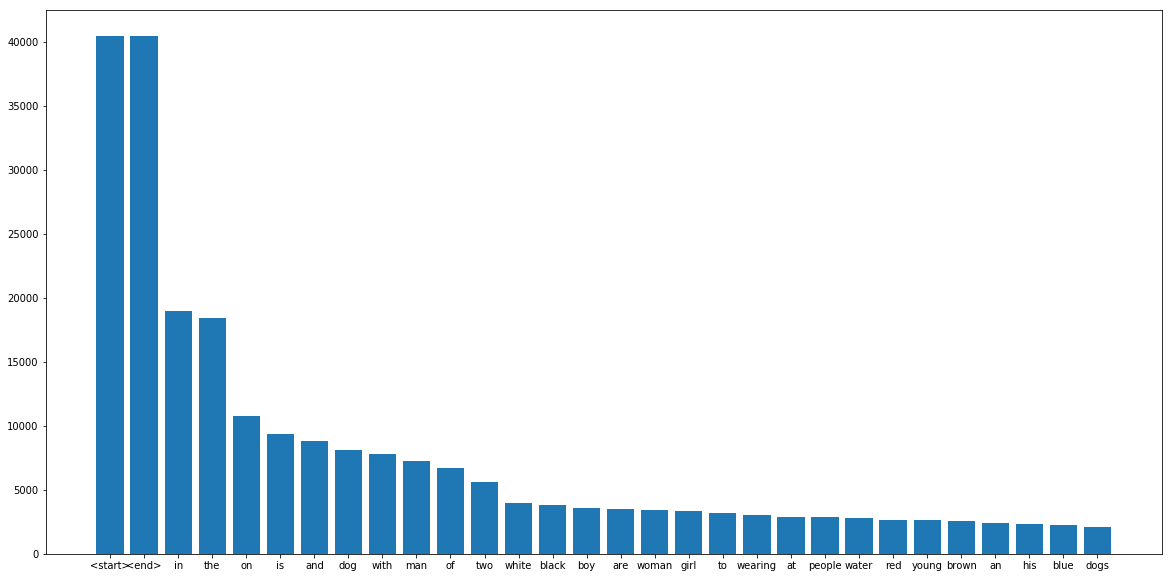

In [21]:
#Visualise the top 30 occuring words in the captions
#write your code here
plt.figure(figsize = (20, 10))
top_words = OrderedDict(val_count.most_common(30))
plt.bar(top_words.keys(), top_words.values())
plt.show()

#### As observed, start and end tokens are most common words (since theu are present in all statements) followed by prepositions and modals

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [22]:
# create the tokenizer
tokenizer = Tokenizer(num_words = 5001 , oov_token='<unk>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(all_annotations)

In [23]:
# Create word-to-index and index-to-word mappings.
# word to index mapping
wordIndex = tokenizer.word_index
indexToWord = tokenizer.index_word

In [24]:
# add the token for padding
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

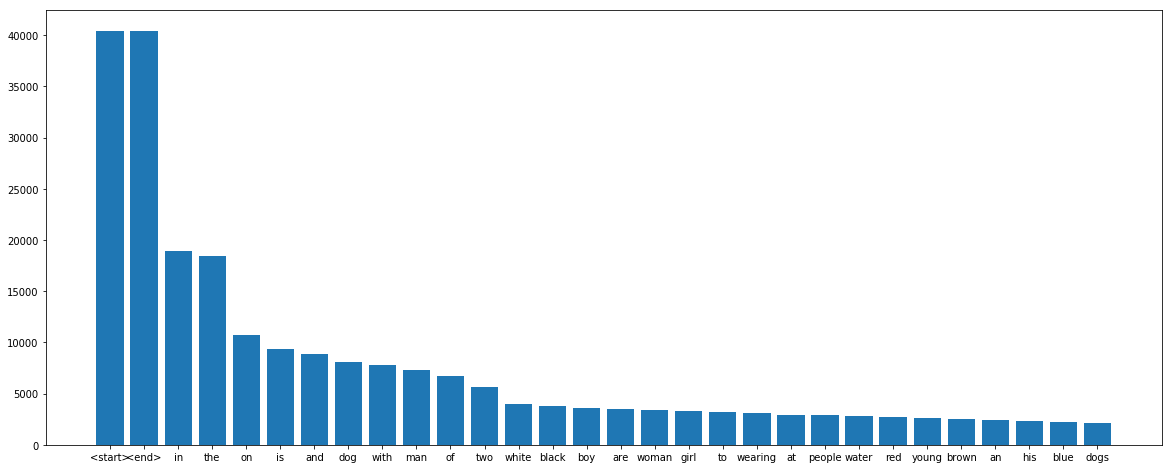

In [25]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
wordCounts = tokenizer.word_counts
plt.figure(figsize=(20, 8))
top_words = OrderedDict(Counter(wordCounts).most_common(30))
plt.bar(top_words.keys(), top_words.values())
plt.show()

In [26]:
# tokenize the captions 
text_sequences = tokenizer.texts_to_sequences(all_annotations)

In [27]:
# max length of the tokenized caption
max_length = max(len(d) for d in text_sequences)
max_length

34

In [28]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
cap_vector= pad_sequences(text_sequences, padding='post') #your code here
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 34)


In [29]:
# tokenize all the captions. 
df['encoded_captions']  = list(cap_vector)
df.head(5)

ID                                       Path  \
0  1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   

                                            Captions  \
0  <start> child in pink dress is climbing up set...   
1      <start> girl going into wooden building <end>   
2  <start> little girl climbing into wooden playh...   
3  <start> little girl climbing the stairs to her...   
4  <start> little girl in pink dress going into w...   

                                    encoded_captions  
0  [2, 42, 4, 90, 169, 7, 119, 53, 394, 12, 391, ...  
1  [2, 19, 313, 64, 193, 117, 3, 0, 0, 0, 0, 0, 0...  
2  [2, 40, 19, 119, 64, 193, 2423, 3, 0, 0, 0, 0,...  
3  [2, 40, 19, 119, 5, 391, 20, 60, 2423, 3, 0, 0...  
4  [2, 40, 19, 4, 90, 169, 313, 64, 193, 2985, 3,...

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [30]:
#write your code here
# define the image size
rows = 299
cols = 299

# function to read image from given path and process it for inception model
def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (rows, cols))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, file_path

# return image and corresponding caption as passed
def load_image(file_path, cap=None):
    img , _ = process_path(file_path)
    return img, cap

# function to load feature vector saved using imagenet earlier and map it to caption
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [31]:
batch_size=64
BUFFER_SIZE = 500

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [32]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input  #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model =  tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

87916544/87910968 [==============================] - 2s 0us/step


In [33]:
# write your code to extract features from each image in the dataset
image_vector = sorted(set(all_img_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(image_vector)
image_dataset = image_dataset.map(process_path, num_parallel_calls=
                                  tf.data.experimental.AUTOTUNE).batch(batch_size)

### create .npy files against each image for the model to process

In [34]:
for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    # we save the features to disk. 
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [35]:
# get encoded captiomns for an image
def getKeyValueLists(keys):
    data = df.loc[df['ID'].isin(keys)]
    return data['Path'].tolist(), data['encoded_captions'].tolist()

In [36]:
# train test split
train_images, val_images = train_test_split(all_img_id, train_size=0.8, random_state = 42)
len(train_images),len(val_images)

(6472, 1619)

In [37]:
# caption and image path arrays for training data
train_image_paths, train_captions = getKeyValueLists(train_images)
len(train_image_paths), len(train_captions)

(32360, 32360)

In [38]:
# caption and image path arrays for validation data
val_image_paths, val_captions = getKeyValueLists(val_images)
len(val_image_paths), len(val_captions)

(8095, 8095)

## Train dataset

In [39]:
#  create a tensor from given data
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_captions))

In [40]:
# Use map to load the numpy files in parallel. The final dataset will be in  (feature, tokenizedCaption) form
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [41]:
# Shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [42]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(64, 64, 2048)
(64, 34)


## Test dataset

In [43]:
#  create a tensor from given data
test_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_captions))

In [44]:
# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [45]:
# Shuffle and batch
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(batch_size,drop_remainder=True)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [46]:
sample_img_batch_test, sample_cap_batch_test = next(iter(test_dataset))
print(sample_img_batch_test.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch_test.shape) #(batch_size,40)

(64, 64, 2048)
(64, 34)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [47]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(train_image_paths) // batch_size
test_num_steps = len(val_image_paths) // batch_size

### Encoder

In [48]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)#build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [49]:
encoder=Encoder(embedding_dim)

### Attention model

In [50]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)# Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

        score = self.V(attention_hidden_layer) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score, axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [51]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)  # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    # reset_state
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


In [52]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [53]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)
dec_input = tf.cast(dec_input, dtype=tf.float32)

In [54]:
predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [55]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')#define your loss object

In [56]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [57]:
# checkpoint_path = "./checkpoints/train"
# ckpt = tf.train.Checkpoint(encoder=encoder,
#                            decoder=decoder,
#                            optimizer = optimizer)
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [58]:
start_epoch = 0
# if ckpt_manager.latest_checkpoint:
#     start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
#     # restoring the latest checkpoint in checkpoint_path
#     ckpt.restore(ckpt_manager.latest_checkpoint)

In [59]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        feature = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, feature, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
            
    avg_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

In [60]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
      # passing the features through the decoder
          predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
          # predictions : (64,8329)
          loss += loss_function(target[:, i], predictions)
        
          predicted_id = tf.argmax(predictions[0])
          # dec_input = tf.expand_dims([predicted_id]*batch_size, 1)

    avg_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

In [61]:
def test_loss_cal(test_dataset):
    total_loss = 0
    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        # print('test_batch', batch)
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss = total_loss/test_num_steps
    return avg_test_loss

In [62]:
EPOCHS = 15
loss_plot = []
test_loss_plot = []
best_test_loss=100

for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    avg_train_loss = total_loss / train_num_steps
    loss_plot.append(avg_train_loss)
    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        # ckpt_manager.save()
        
    print ('Epoch {} training Loss {:.6f}, test loss : {:.6f}'.format(epoch + 1,total_loss/train_num_steps, best_test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 2.5170
Epoch 1 Batch 100 Loss 1.4342
Epoch 1 Batch 200 Loss 1.4244
Epoch 1 Batch 300 Loss 1.3657
Epoch 1 Batch 400 Loss 1.2815
Epoch 1 Batch 500 Loss 1.0950


  7%|▋         | 1/15 [04:29<1:02:54, 269.59s/it]

Test loss has been reduced from 100.000 to 1.536
Epoch 1 training Loss 1.371941, test loss : 1.535905
Time taken for 1 epoch 269.58829522132874 sec

Epoch 2 Batch 0 Loss 1.3879
Epoch 2 Batch 100 Loss 1.0356
Epoch 2 Batch 200 Loss 1.1651
Epoch 2 Batch 300 Loss 1.0317
Epoch 2 Batch 400 Loss 1.1314
Epoch 2 Batch 500 Loss 0.9159


 13%|█▎        | 2/15 [07:46<53:41, 247.79s/it]  

Test loss has been reduced from 1.536 to 1.444
Epoch 2 training Loss 1.104878, test loss : 1.443897
Time taken for 1 epoch 196.9219605922699 sec

Epoch 3 Batch 0 Loss 1.1363
Epoch 3 Batch 100 Loss 0.9865
Epoch 3 Batch 200 Loss 0.9154
Epoch 3 Batch 300 Loss 0.9586
Epoch 3 Batch 400 Loss 1.0831
Epoch 3 Batch 500 Loss 1.0240


 20%|██        | 3/15 [11:03<46:28, 232.42s/it]

Test loss has been reduced from 1.444 to 1.384
Epoch 3 training Loss 1.013003, test loss : 1.384378
Time taken for 1 epoch 196.54479384422302 sec

Epoch 4 Batch 0 Loss 1.0469
Epoch 4 Batch 100 Loss 0.9355
Epoch 4 Batch 200 Loss 0.9794
Epoch 4 Batch 300 Loss 0.9043
Epoch 4 Batch 400 Loss 0.9357
Epoch 4 Batch 500 Loss 0.8947


 27%|██▋       | 4/15 [14:19<40:38, 221.72s/it]

Test loss has been reduced from 1.384 to 1.341
Epoch 4 training Loss 0.951014, test loss : 1.340758
Time taken for 1 epoch 196.76464700698853 sec

Epoch 5 Batch 0 Loss 0.9408
Epoch 5 Batch 100 Loss 0.9069
Epoch 5 Batch 200 Loss 0.8152
Epoch 5 Batch 300 Loss 0.9094
Epoch 5 Batch 400 Loss 0.8169
Epoch 5 Batch 500 Loss 0.8397


 33%|███▎      | 5/15 [17:36<35:42, 214.24s/it]

Test loss has been reduced from 1.341 to 1.302
Epoch 5 training Loss 0.900851, test loss : 1.302282
Time taken for 1 epoch 196.79775524139404 sec

Epoch 6 Batch 0 Loss 1.1425
Epoch 6 Batch 100 Loss 0.8199
Epoch 6 Batch 200 Loss 0.8563
Epoch 6 Batch 300 Loss 0.8487
Epoch 6 Batch 400 Loss 0.8562
Epoch 6 Batch 500 Loss 0.8900


 40%|████      | 6/15 [20:52<31:19, 208.83s/it]

Test loss has been reduced from 1.302 to 1.270
Epoch 6 training Loss 0.857605, test loss : 1.269769
Time taken for 1 epoch 196.17912006378174 sec

Epoch 7 Batch 0 Loss 0.9784
Epoch 7 Batch 100 Loss 0.7690
Epoch 7 Batch 200 Loss 0.7493
Epoch 7 Batch 300 Loss 0.9698
Epoch 7 Batch 400 Loss 0.8907
Epoch 7 Batch 500 Loss 0.8239


 47%|████▋     | 7/15 [24:10<27:22, 205.35s/it]

Test loss has been reduced from 1.270 to 1.242
Epoch 7 training Loss 0.816842, test loss : 1.241972
Time taken for 1 epoch 197.2420356273651 sec

Epoch 8 Batch 0 Loss 0.8220
Epoch 8 Batch 100 Loss 0.8022
Epoch 8 Batch 200 Loss 0.7333
Epoch 8 Batch 300 Loss 0.7859
Epoch 8 Batch 400 Loss 0.8547
Epoch 8 Batch 500 Loss 0.7681


 53%|█████▎    | 8/15 [27:25<23:37, 202.47s/it]

Test loss has been reduced from 1.242 to 1.218
Epoch 8 training Loss 0.778897, test loss : 1.218284
Time taken for 1 epoch 195.74316358566284 sec

Epoch 9 Batch 0 Loss 0.8683
Epoch 9 Batch 100 Loss 0.6942
Epoch 9 Batch 200 Loss 0.7167
Epoch 9 Batch 300 Loss 0.6826
Epoch 9 Batch 400 Loss 0.7473
Epoch 9 Batch 500 Loss 0.7257


 60%|██████    | 9/15 [30:42<20:04, 200.75s/it]

Test loss has been reduced from 1.218 to 1.190
Epoch 9 training Loss 0.743076, test loss : 1.190260
Time taken for 1 epoch 196.72856736183167 sec

Epoch 10 Batch 0 Loss 0.8136
Epoch 10 Batch 100 Loss 0.7442
Epoch 10 Batch 200 Loss 0.6777
Epoch 10 Batch 300 Loss 0.6768
Epoch 10 Batch 400 Loss 0.7284
Epoch 10 Batch 500 Loss 0.6767


 67%|██████▋   | 10/15 [33:59<16:37, 199.53s/it]

Test loss has been reduced from 1.190 to 1.173
Epoch 10 training Loss 0.708655, test loss : 1.172634
Time taken for 1 epoch 196.67484402656555 sec

Epoch 11 Batch 0 Loss 0.8626
Epoch 11 Batch 100 Loss 0.6588
Epoch 11 Batch 200 Loss 0.5864
Epoch 11 Batch 300 Loss 0.7238
Epoch 11 Batch 400 Loss 0.6796
Epoch 11 Batch 500 Loss 0.6325


 73%|███████▎  | 11/15 [37:15<13:14, 198.71s/it]

Test loss has been reduced from 1.173 to 1.150
Epoch 11 training Loss 0.676573, test loss : 1.149687
Time taken for 1 epoch 196.79359221458435 sec

Epoch 12 Batch 0 Loss 0.8082
Epoch 12 Batch 100 Loss 0.7155
Epoch 12 Batch 200 Loss 0.5912
Epoch 12 Batch 300 Loss 0.7040
Epoch 12 Batch 400 Loss 0.6282
Epoch 12 Batch 500 Loss 0.6702


 80%|████████  | 12/15 [40:32<09:54, 198.02s/it]

Test loss has been reduced from 1.150 to 1.130
Epoch 12 training Loss 0.647338, test loss : 1.130268
Time taken for 1 epoch 196.43035006523132 sec

Epoch 13 Batch 0 Loss 0.7497
Epoch 13 Batch 100 Loss 0.6350
Epoch 13 Batch 200 Loss 0.6275
Epoch 13 Batch 300 Loss 0.7051
Epoch 13 Batch 400 Loss 0.6540
Epoch 13 Batch 500 Loss 0.6130


 87%|████████▋ | 13/15 [43:48<06:35, 197.53s/it]

Test loss has been reduced from 1.130 to 1.114
Epoch 13 training Loss 0.619353, test loss : 1.113608
Time taken for 1 epoch 196.38219571113586 sec

Epoch 14 Batch 0 Loss 0.7220
Epoch 14 Batch 100 Loss 0.6618
Epoch 14 Batch 200 Loss 0.7047
Epoch 14 Batch 300 Loss 0.6060
Epoch 14 Batch 400 Loss 0.5284
Epoch 14 Batch 500 Loss 0.5234


 93%|█████████▎| 14/15 [47:05<03:17, 197.24s/it]

Test loss has been reduced from 1.114 to 1.100
Epoch 14 training Loss 0.593403, test loss : 1.100196
Time taken for 1 epoch 196.55320239067078 sec

Epoch 15 Batch 0 Loss 0.7487
Epoch 15 Batch 100 Loss 0.6207
Epoch 15 Batch 200 Loss 0.5044
Epoch 15 Batch 300 Loss 0.6544
Epoch 15 Batch 400 Loss 0.5666
Epoch 15 Batch 500 Loss 0.5392


100%|██████████| 15/15 [50:21<00:00, 196.95s/it]

Test loss has been reduced from 1.100 to 1.086
Epoch 15 training Loss 0.570321, test loss : 1.085515
Time taken for 1 epoch 196.28623151779175 sec



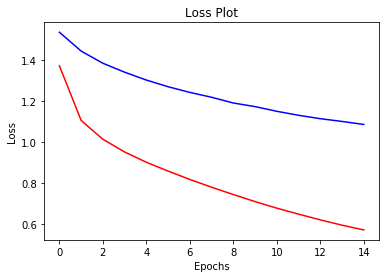

In [63]:
plt.plot(loss_plot, color = 'red')
plt.plot(test_loss_plot, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### As observed, both train and test loss decrease with increaing epochs

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [71]:
attention_features_shape = 64 #assign from relevant variable above
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(process_path(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()#extract the predicted id(embedded value) which carries the max value
        
        #map the id to the word from tokenizer and append the value to the result list
        predicted_word = tokenizer.index_word[predicted_id]
        result.append(predicted_word)
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [72]:
def plot_attmap(result,  attention_plot , image):
    temp_image = np.array(PIL.Image.open(image))
    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [73]:
from nltk.translate.bleu_score import sentence_bleu

In [74]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [107]:
rid = np.random.randint(0, len(val_image_paths))
test_image = val_image_paths[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in val_captions[rid] if i not in [0]])
real_caption=filt_text(real_caption)      

print(rid, test_image, real_caption)

4621 Flickr8K/Images/3235746553_a40416c00e.jpg brown dog is running on sand next to the ocean


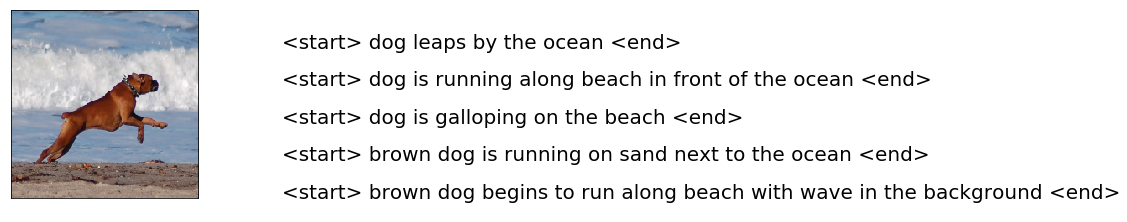

In [108]:
# view the test image and it's captions
image_desc_plotter(rid, rid+1, val_image_paths)

BELU score: 16.514456476895408
Real Caption: brown dog is running on sand next to the ocean
Prediction Caption: brown dog leaps over the dirt with ball in its tongue


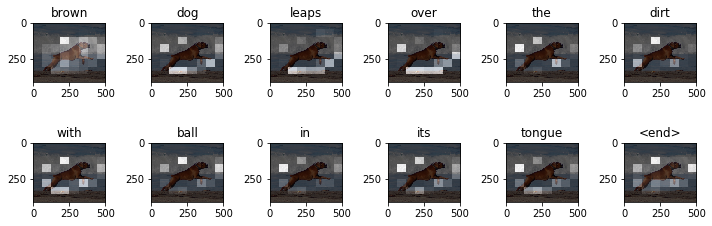

In [109]:
# predict using greedy search
result, attention_plot,pred_test = evaluate(test_image)
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

# calculate bleu score 
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))#set your weights)
print(f"BELU score: {score*100}")
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)